# Manning Publications: Data Science Bookcamp
## Case Study 3: Tracking Disease Outbreaks Using News Headlines¶
### Part 3: clustering headlines by location
                                                2020 Jamie Shaffer

In [1]:
import re                         # 2.2.1
import numpy as np
import pandas as pd               # 0.25.0
import geonamescache              # 1.1.0
#import unidecode                  # has no __version__
from unidecode import unidecode

# PEP 484 type hints are easier with this
from typing import Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

for library in [re,pd,geonamescache]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

're'  version is  2.2.1
'pandas'  version is  0.25.0
'geonamescache'  version is  1.1.0


## GLOBALS

In [2]:
## GLOBALS

GLOBAL_FILL_STRING = 'not_specified'

# For debugging, set this to 1
debug = 0

# Headlines with cities are in this file:
fname1= r"C:\Users\jshaf\GitHub\data-science-portfolio\coursework"
fname2 = r"\manning-data-science-bookcamp\jupyter_notebooks\s2_headlines_lat_long_cc.csv"
fname = fname1 + fname2

# First step when using geonamescache
gc = geonamescache.GeonamesCache()  

# Note that the primary dataframe, df, will be used as a global, too

## FUNCTIONS

In [3]:
def plot_color_coded_map(lat_list, lon_list, \
                         colorplan='g', zoom_list=[-180,-90,180,90],\
                        ax=None)-> Basemap:
    '''Take in a latitude list, longitude list, color coding plan, and zoom_list, and plot a map
        INPUTS:
            lat_list : list of latitudes as floats
            lon_list : list of longitudues as floats
            colorplan: (optional) list of colors to use. Default: all green
            zoom_list: (optional) list of map corners allowing for zooming. Default: full earth
        OUTPUTS:
            map will be drawn
        RETURN:
            m        : map_plotter, in case you want to add something on top of the map
    '''
    fig = plt.figure(figsize=(12, 8))
    # Note that 'cyl' is the default projection
    if (ax == None):
        map_plotter = Basemap(projection='cyl',\
                             llcrnrlon = m_llcrnrlon,\
                             llcrnrlat = m_llcrnrlat,\
                             urcrnrlon = m_urcrnrlon,\
                             urcrnrlat = m_urcrnrlat )  
    else:
                map_plotter = Basemap(projection='cyl',\
                             llcrnrlon = m_llcrnrlon,\
                             llcrnrlat = m_llcrnrlat,\
                             urcrnrlon = m_urcrnrlon,\
                             urcrnrlat = m_urcrnrlat,\
                                     ax = ax)  

    map_plotter.drawcoastlines()
    map_plotter.shadedrelief()


    map_plotter.scatter(lon_list,lat_list,latlon=True, c=colorplan)
    
    return map_plotter

In [4]:
# https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Handy way to build the legend
def get_legend_markers(D_label_color, marker="o", marker_kws={"linestyle":""}):
    """
    Usage: plt.legend(*legend_vars(D_taxon_color),
                      loc="lower center",
                      bbox_to_anchor=(0.5,-0.15),
                      fancybox=True, shadow=True,
                      prop={'size':15})

    Input: Dictionary object of {label:color}
    Output: Tuple of markers and labels
    """
    # Any marker you want to have in the legend must be put on the plot; this makes sure that it's on there.
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=marker, **marker_kws) for color in D_label_color.values()]
    return (markers, D_label_color.keys())

## MAIN

### Step 1: Revisit the raw data

In [5]:
df = pd.read_csv(fname)  # read the headlines with city/country information

In [6]:
df.head()

,headline,city,country,latitude,longitude,cityduplicates,countrycode
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,25.93315,-80.16255,1,US
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN


In [7]:

# setting up the zoom -- here's the whole world
m_llcrnrlon = -180
m_llcrnrlat = -90

m_urcrnrlon = 180
m_urcrnrlat = 90


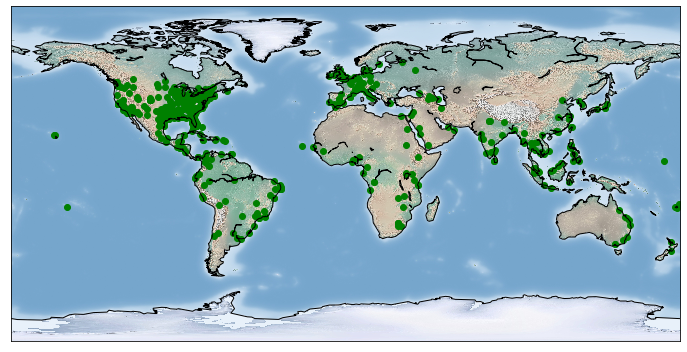

In [8]:
lat_list = list(df['latitude'])
lon_list = list(df['longitude'])
plot_color_coded_map(lat_list, lon_list)

In [9]:
colorplan = np.where(df["cityduplicates"]==1,'b','r')


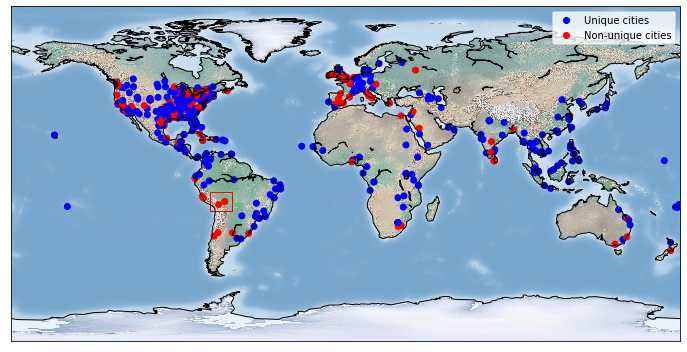

In [10]:
m = plot_color_coded_map(lat_list, lon_list, colorplan)

# Add a box around 
ax = plt.gca()  # get current axes
import matplotlib.patches as patches
rect = patches.Rectangle( (-73,-20), width=12, height=10, fill=False, color='r')
ax.add_patch(rect)

ax = plt.gca()
D_label_color = {"Unique cities":"blue", "Non-unique cities":"red"}
ax.legend(*get_legend_markers(D_label_color))

The clusters composed entirely of cities that had multiple possibilities should be watched closely -- note the
red box along the west coast of South America. It's possible that looking 
at the city names might put the actual cities in another existing cluster. This could make the difference 
between an "outbreak" and a "pandemic."

### Step 2: Try out KMeans clustering

In [11]:
from sklearn.cluster import KMeans

# create a list of lat, long pairs
lat_long_list = []

for i in df.iterrows():
    di = i[0]
    #print("di is {} and i is {} {}".format(di,type(di),di))
    #print("    lat {} and long {}".format(df.loc[di,'latitude'],df.loc[di,'longitude']))
    lat_long_list.append([df.loc[di,'latitude'],df.loc[di,'longitude']])
    
cluster_model = KMeans(n_clusters=2)   
cluster_list = cluster_model.fit_predict(lat_long_list)

In [12]:
df['Kcluster2'] = cluster_list

In [13]:
df.head()

,headline,city,country,latitude,longitude,cityduplicates,countrycode,Kcluster2
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY,0
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US,0
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US,0
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,25.93315,-80.16255,1,US,0
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN,1


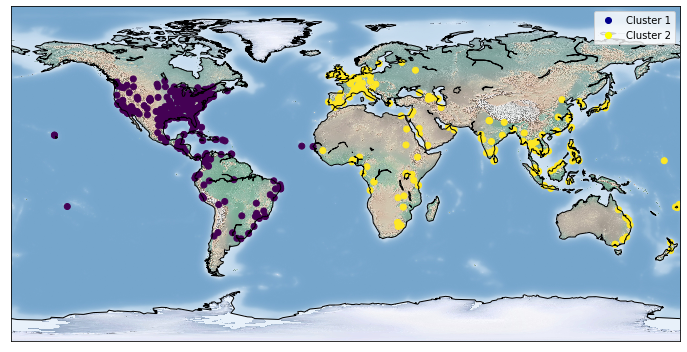

In [14]:
colorplan = list(df["Kcluster2"])

plot_color_coded_map(lat_list, lon_list, colorplan)

ax = plt.gca()
D_label_color = {"Cluster 1":"darkblue", "Cluster 2":"yellow"}
ax.legend(*get_legend_markers(D_label_color))

Clustering using KMeans with k=2 clearly has issues --> note the islands just off the west coast of Africa.

Let's search for a better k value.

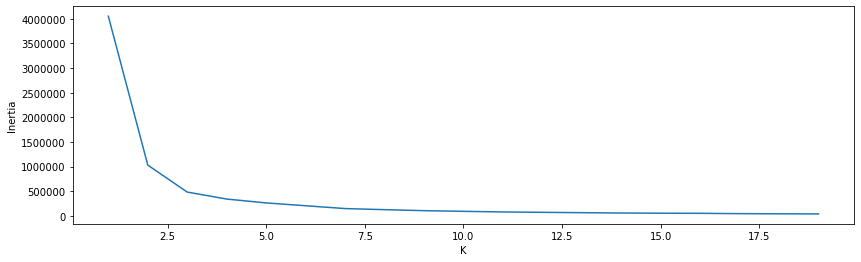

In [15]:
k_values = range(1, 20)
inertia_values = [KMeans(k).fit(lat_long_list).inertia_
                  for k in k_values]
plt.figure(figsize=(14, 4))
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')

plt.show()

KMeans of about 3 or 4 seem to about all we need. Let's plot both and compare.

In [16]:
cluster_model = KMeans(n_clusters=3)   
cluster_list = cluster_model.fit_predict(lat_long_list)
df['Kcluster3'] = cluster_list
                                         
cluster_model = KMeans(n_clusters=4)   
cluster_list = cluster_model.fit_predict(lat_long_list)
df['Kcluster4'] = cluster_list                                        

Text(0.5, 1.0, 'KMeans for K = 4')

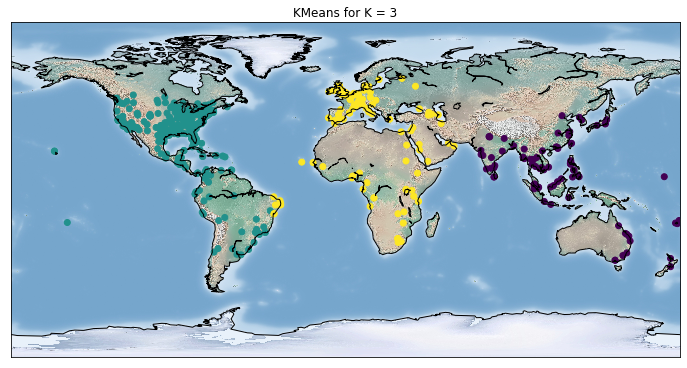

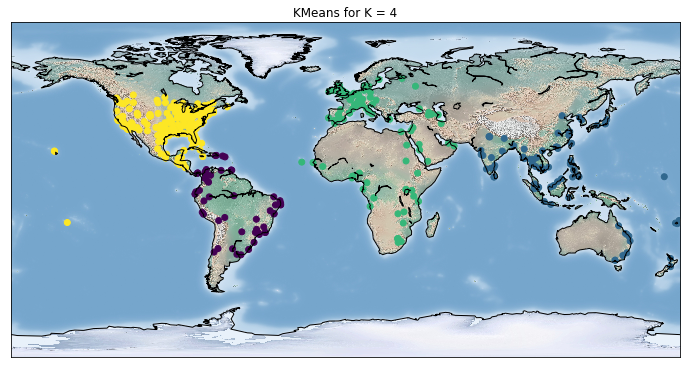

In [17]:
# TODO: get these plotted side by side -- make the subplots first and pass axes to make the map?
#fig, axes = plt.subplots(2, 1, figsize=(20, 10))

colorplan3 = list(df["Kcluster3"])
m1 = plot_color_coded_map(lat_list, lon_list, colorplan3) #, axes[0])
ax = plt.gca()
ax.set_title('KMeans for K = 3')

colorplan4 = list(df["Kcluster4"])
m2 = plot_color_coded_map(lat_list, lon_list, colorplan4) #, axes[1])
ax = plt.gca()
ax.set_title('KMeans for K = 4')

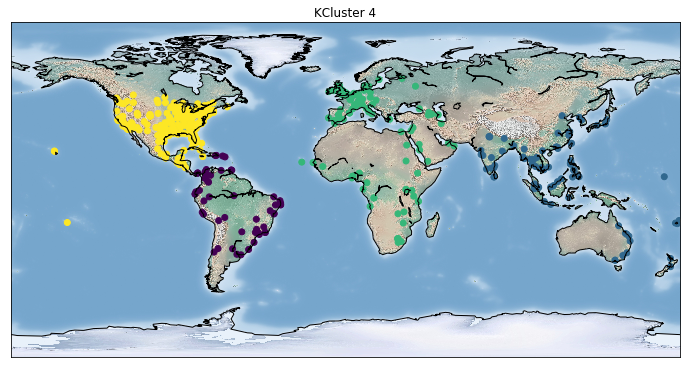

In [18]:
colorplan = list(df["Kcluster4"])
plot_color_coded_map(lat_list, lon_list, colorplan)

plt.title("KCluster 4")
plt.show()

### Step 3: Try out DBSCAN

In [19]:
# Values tried + results
# e = 0.1, mp = 10   --> 1 cluster -- but it's all -1 which means "outside a cluster!"
# e = 1.0, mp = 10   --> 8 clusters
# e = 10,  mp = 10   --> 6 clusters, roughly the same as subcontinent regions
# e = 10,  mp =  5   --> 10 clusters
epsilon=10
min_points = 5

In [20]:
from sklearn.cluster import DBSCAN
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
headline_clusters = cluster_model.fit_predict(lat_long_list)

In [21]:
df['DBSCAN_cluster'] = headline_clusters
df['DBSCAN_cluster'].nunique()

10

In [22]:
cc1 = df['DBSCAN_cluster'].unique()
cc2 = np.sort(cc1, axis=-1, kind='quicksort', order=None)
cc2

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

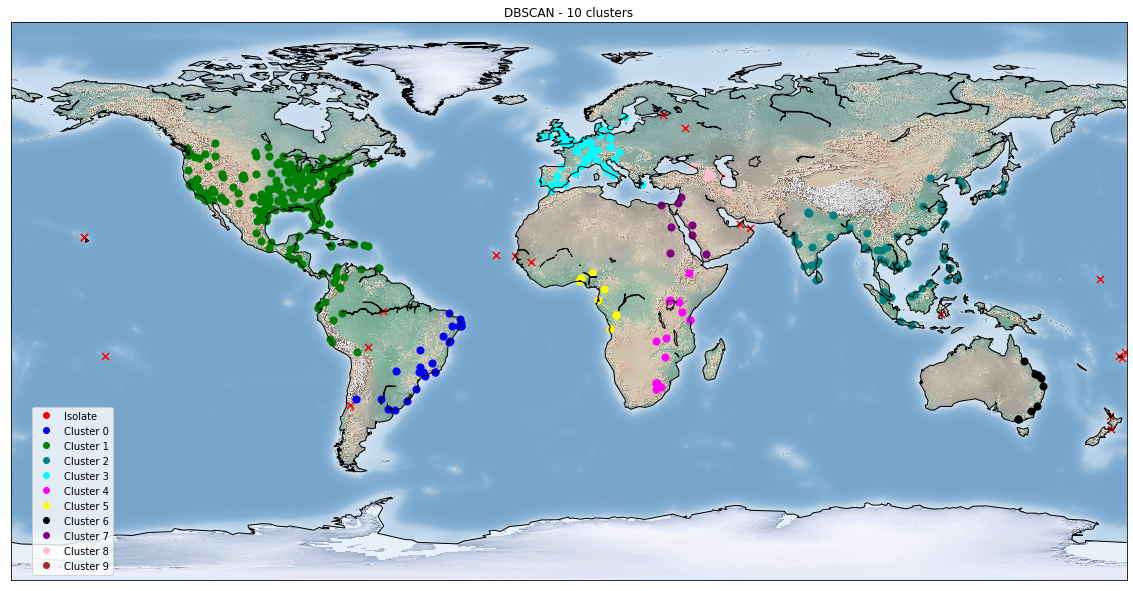

In [23]:
# Working out colors and legend match-up

color_order =['blue', 'green', 'teal', 'cyan', 'magenta', 'yellow', 'black', \
                                    'purple', 'pink', 'brown', 'orange', 'red', 'coral',\
                                    'lightblue', 'lime', 'lavender', 'turquoise', 'darkgreen', \
                                    'tan', 'salmon', 'gold']
map_plotter = Basemap(projection='cyl',\
                             llcrnrlon = m_llcrnrlon,\
                             llcrnrlat = m_llcrnrlat,\
                             urcrnrlon = m_urcrnrlon,\
                             urcrnrlat = m_urcrnrlat)  
D_label_color = {}
plt.figure(figsize=(20, 20))
map_plotter.drawcoastlines()
map_plotter.shadedrelief()
spot_size=50

for c in range(-1,len(cc2)):
    mini_df = df[df['DBSCAN_cluster']==c]
    lat_list = mini_df['latitude']
    lon_list = mini_df['longitude']
    if (c == -1):  
        map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=spot_size)
        D_label_color["Isolate"] = 'red'
    else:
        map_plotter.scatter(lon_list,lat_list,latlon=True, c=color_order[c],s=spot_size)
        str_cluster = "Cluster " + str(c)
        D_label_color[str_cluster]=color_order[c]

ax = plt.gca()    

plt.title("DBSCAN - 10 clusters")
ax.legend(*get_legend_markers(D_label_color),bbox_to_anchor=(0, 0, .096, .32)) ##bbox_to_anchor=(0, 0, 1.09, 1))

In [24]:
df.head()

,headline,city,country,latitude,longitude,cityduplicates,countrycode,Kcluster2,Kcluster3,Kcluster4,DBSCAN_cluster
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY,0,1,0,0
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US,0,1,3,1
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US,0,1,3,1
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,25.93315,-80.16255,1,US,0,1,3,1
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN,1,0,1,2


In [25]:
# DBSCAN result with 10 groupings seems most reasonable
df.drop(['Kcluster2','Kcluster3','Kcluster4'],axis=1,inplace=True)
df.head()

,headline,city,country,latitude,longitude,cityduplicates,countrycode,DBSCAN_cluster
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY,0
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US,1
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US,1
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,25.93315,-80.16255,1,US,1
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN,2


In [26]:
df.to_csv('s3_headline_clusters.csv')